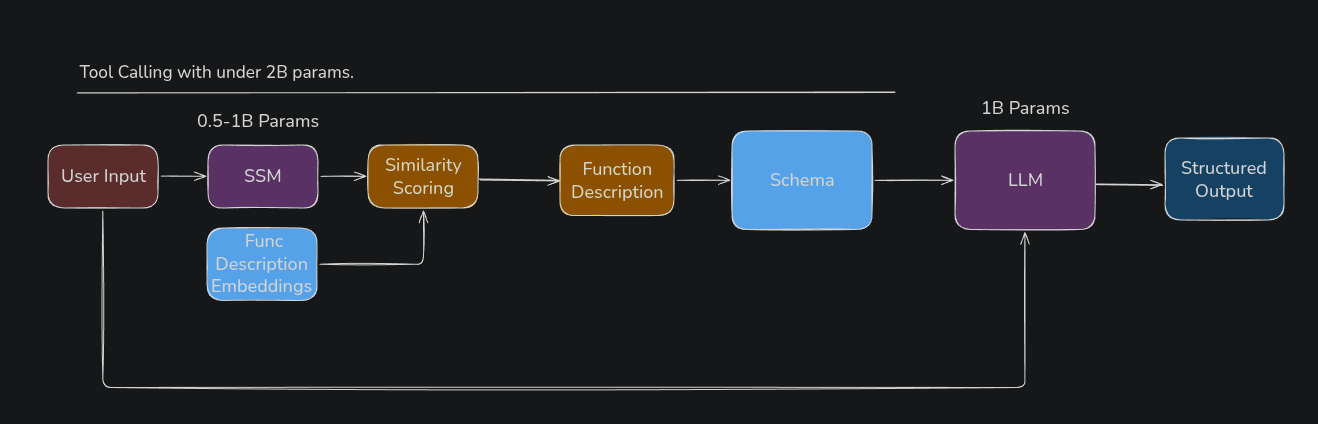

In [13]:
from langchain_core.runnables import Runnable

from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

from langchain_ollama import ChatOllama
import datetime

In [2]:
llm = ChatOllama(
    base_url="http://localhost:11434",
    model="llama3.2:3B",
    temperature=0,
    keep_alive="30m"
)

In [ ]:
# NOTE: Try using a well worded system prompt, and structured output to determine if a request pertains to task management.

In [14]:
from typing import Literal
from pydantic import BaseModel, Field

class CreateTask(BaseModel):
    task_name: str
    is_complete: bool | None
    date: datetime.date | None

# class EditTask(BaseModel):

class IsValid(BaseModel):
    is_valid_request: bool = Field(default=..., description="A boolean indicating if the user's input is valid and relevant to task management.")

class RouteRequest(BaseModel):
    request_type: Literal["create", "edit", "delete"] = Field(default=..., description="A string indicating indicating the tpye of request made. Valid inputs are: 'create', 'edit', and 'delete'.")


In [15]:
validator_llm = llm.with_structured_output(IsValid)

router_llm = llm.with_structured_output(RouteRequest)

In [18]:
from langchain_core.prompts import ChatPromptTemplate

# template for the llm in-charge of validating user input.

validator_template = ChatPromptTemplate.from_messages(
    [
        # role, message
        ("system", "You are a security and validation system. You analyze text and determine if it relates to 'task managment': specifically, you verify that a user's request relates to creating tasks, editing tasks, or deleting tasks. You classify all other input as invalid."),
        ("{user_input}"),
    ]
)

# template for the llm in-charge of routing a user request to the proper subgraph (Create, Edit, or Delete)

router_template = ChatPromptTemplate.from_messages(
    [
        # (role, message)
        SystemMessage(content="You are a routing system. You analyze a user's request and determine it pertains one of the following options: creation of a task, modification of a task, or deletetion of a task."), # TODO: expand this to include specific instructions for each request type
        ("{user_input}")
    ]
)

In [19]:
validator_chain: Runnable = validator_template | validator_llm
router_chain: Runnable = router_template | router_llm


In [ ]:
user_input = "Mark the go for a run task as complete." 

validation = validator_chain.invoke(user_input)

if validation.is_valid_request:
    out = router_chain.invoke(user_input)
    print(out.request_type)

# OOPS: the user_input of ("Mark the go for a run task as complete.") should print 'edit'

create
